# Multilingual Agent Evaluation Results Visualization

This notebook creates interactive boxplots to visualize the evaluation results of LLM agents across different models and languages.

In [30]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

In [11]:
# Load all result files
results_dir = Path('results')
results_data = []

lang_to_country = {
    "nld": "NL", 
    "pol": "PL",
    "por": "PT", 
    "est": "EE",
    "deu": "DE",
    "fra": "FR", 
    "eng": "GB",
}

for json_file in results_dir.glob('*.json'):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    # Extract model name and language from filename or data
    model_name = data.get('model_name', '')
    language = data.get('language', '')
    
    # Get metric scores
    metric_scores = data['evaluation_results']['global_metrics']['average_scores_by_metric']
    
    # Add each metric score as a separate row
    for metric_name, score in metric_scores.items():
        results_data.append({
            'model': model_name,
            'language': language,
            'metric': metric_name,
            'score': score,
            'filename': json_file.name
        })

# Create DataFrame
df = pd.DataFrame(results_data)
df['country_code'] = df['language'].map(lang_to_country)
print(f"Loaded {len(df)} data points")
print(f"Models: {sorted(df['model'].unique())}")
print(f"Languages: {sorted(df['language'].unique())}")
print(f"Metrics: {sorted(df['metric'].unique())}")
df.head()

Loaded 84 data points
Models: ['HuggingFaceTB/SmolLM3-3B', 'Qwen/Qwen3-14B', 'Qwen/Qwen3-4B', 'Qwen/Qwen3-8B', 'mistralai/Mistral-Nemo-Instruct-2407', 'openai/gpt-oss-20b']
Languages: ['deu', 'eng', 'est', 'fra', 'nld', 'pol', 'por']
Metrics: ['Argument Correctness', 'Tool Correctness']


,model,language,metric,score,filename,country_code
0,HuggingFaceTB/SmolLM3-3B,nld,Tool Correctness,0.8000,agent_SmolLM3-3B_nld_Latn.json,NL
1,HuggingFaceTB/SmolLM3-3B,nld,Argument Correctness,0.6000,agent_SmolLM3-3B_nld_Latn.json,NL
2,openai/gpt-oss-20b,pol,Tool Correctness,1.0000,agent_gpt-oss-20b_pol_Latn.json,PL
3,openai/gpt-oss-20b,pol,Argument Correctness,0.8619,agent_gpt-oss-20b_pol_Latn.json,PL
4,Qwen/Qwen3-8B,por,Tool Correctness,0.9667,agent_Qwen3-8B_por_Latn.json,PT


In [ ]:
# Use to convert 'country_code' into a flag icon
def country_to_flag(code):
    return chr(ord(code[0]) + 127397) + chr(ord(code[1]) + 127397)

In [16]:
# Clean model names for better visualization
def clean_model_name(model_name):
    """Extract clean model name from full model path"""
    if '/' in model_name:
        return model_name.split('/')[-1]
    return model_name

df['model_clean'] = df['model'].apply(clean_model_name)
print(f"Clean model names: {sorted(df['model_clean'].unique())}")

Clean model names: ['Mistral-Nemo-Instruct-2407', 'Qwen3-14B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM3-3B', 'gpt-oss-20b']


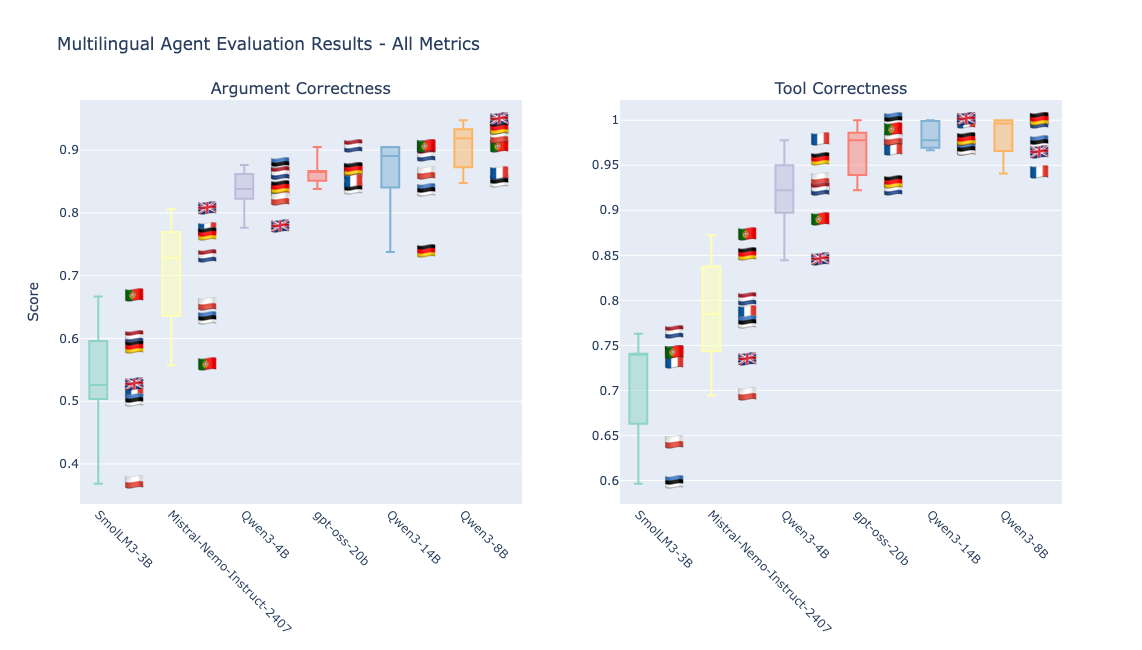

In [104]:
# Get unique metrics
metrics = sorted(df['metric'].unique())
n_metrics = len(metrics)

# Create combined subplot with all metrics
fig = make_subplots(
    rows=1, cols=n_metrics,
    subplot_titles=metrics,
    horizontal_spacing=0.1
)

colors = px.colors.qualitative.Set3
model_positions = {model: idx for idx, model in enumerate(model_order)}
for i, metric in enumerate(metrics):
    # Filter data for this metric
    metric_data = df[df['metric'] == metric]
    
    # Sort models by median performance
    model_medians = metric_data.groupby('model_clean')['score'].median().sort_values()
    model_order = model_medians.index.tolist()
    
    # Create box plot for each model
    for j, model in enumerate(model_order):
        model_data = metric_data[metric_data['model_clean'] == model]
        model_scores = model_data['score']
        model_languages = model_data['language']
        country_codes = model_data["country_code"]
        
        # Create custom hover text with language information
        hover_text = [f"Model: {model}<br>Language: {lang}<br>Score: {score}" 
                      for lang, score in zip(model_languages, model_scores)]
    

        fig.add_trace(
            go.Box(
                y=model_scores,
                name=model,
                boxpoints=False,  # no dots
                marker=dict(color=colors[j % len(colors)]),
                showlegend=False,
            ),
            row=1, col=i+1
        )


        x_flags = [model_positions[model] + 0.9] * len(model_scores) 
        fig.add_trace(
            go.Scatter(
                x=x_flags,
                y=model_scores,
                mode="text",
                text=[country_to_flag(c) for c in country_codes],
                textfont=dict(size=18),
                hovertext=hover_text,
                hovertemplate="%{hovertext}<extra></extra>",
                showlegend=False,
                name="",  
            ),
            row=1, col=i+1
        )

    
    # Update x-axis for this subplot
    fig.update_xaxes(
        tickangle=45,
        row=1, col=i+1
    )
    
    # Update y-axis for this subplot
    fig.update_yaxes(
        title_text="Score" if i == 0 else "",
        row=1, col=i+1
    )

    # hack to remove flag scores from x-label
    # turn model_positions into: {'Mistral-Nemo-Instruct-2407': 0, '': 1, 'SmolLM3-3B': 2, '': 3, 'Qwen3-4B': 4,...
    new_x_positions = {}
    pos = 0
    for model in model_positions.keys():
        new_x_positions[model] = pos
        pos += 1
        new_x_positions[""] = pos  # add empty label
        pos += 1

    fig.update_xaxes(
        tickmode='array',
        tickvals=list(new_x_positions.values()),
        ticktext=list(new_x_positions.keys()),  # keep model names
        tickangle=45,
        row=1, col=i+1
    )


fig.update_layout(
    title="Multilingual Agent Evaluation Results - All Metrics",
    height=650,
    showlegend=False
)


fig.show()

In [105]:
# Export interactive visualizations as HTML files
import os

# Create docs directory if it doesn't exist
docs_dir = 'docs'
os.makedirs(docs_dir, exist_ok=True)

print("Exporting interactive visualizations to HTML...")

# Export the combined subplot
fig.write_html(f"{docs_dir}/combined_metrics_boxplot.html")
print("✓ Exported combined metrics boxplot")

Exporting interactive visualizations to HTML...
✓ Exported combined metrics boxplot


In [107]:
# Create detailed heatmap breaking down by test categories
# Load detailed test results for each category
detailed_results = []

for json_file in results_dir.glob('*.json'):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    model_name = data.get('model_name', '')
    language = data.get('language', '')
    
    # Process individual test results
    test_results = data['evaluation_results']['test_results']
    
    for test_result in test_results:
        eval_item_id = test_result['eval_item_id']
        
        # Categorize based on ID ranges
        if 1 <= eval_item_id <= 5 or 41 <= eval_item_id <= 45:
            category = 'no_tool_call'
        elif 6 <= eval_item_id <= 25:
            category = 'absolute_date'
        elif 26 <= eval_item_id <= 40:
            category = 'relative_date'
        else:
            continue  # Skip if outside expected ranges
            
        # Extract metrics scores for this test
        found_metrics = set()
        for metric_data in test_result['metrics_data']:
            detailed_results.append({
                'model': model_name,
                'language': language,
                'category': category,
                'metric': metric_data['name'],
                'score': metric_data['score'],
                'eval_item_id': eval_item_id
            })
            found_metrics.add(metric_data['name'])
        
        # For no_tool_call category, if "Argument Correctness" is missing, assume 1.0
        if category == 'no_tool_call' and 'Argument Correctness' not in found_metrics:
            detailed_results.append({
                'model': model_name,
                'language': language,
                'category': category,
                'metric': 'Argument Correctness',
                'score': 1.0,
                'eval_item_id': eval_item_id
            })

# Create detailed DataFrame
detailed_df = pd.DataFrame(detailed_results)
detailed_df['model_clean'] = detailed_df['model'].apply(clean_model_name)
detailed_df['country_code'] = detailed_df['language'].map(lang_to_country)


print(f"Loaded {len(detailed_df)} detailed test results")
print(f"Categories: {sorted(detailed_df['category'].unique())}")

# Create language-category combinations
detailed_df['lang_category'] = detailed_df['language'] + '_' + detailed_df['category']

detailed_df.head()

Loaded 3780 detailed test results
Categories: ['absolute_date', 'no_tool_call', 'relative_date']


,model,language,category,metric,score,eval_item_id,model_clean,country_code,lang_category
0,HuggingFaceTB/SmolLM3-3B,nld,no_tool_call,Tool Correctness,1.0,1,SmolLM3-3B,NL,nld_no_tool_call
1,HuggingFaceTB/SmolLM3-3B,nld,no_tool_call,Argument Correctness,1.0,1,SmolLM3-3B,NL,nld_no_tool_call
2,HuggingFaceTB/SmolLM3-3B,nld,no_tool_call,Tool Correctness,1.0,2,SmolLM3-3B,NL,nld_no_tool_call
3,HuggingFaceTB/SmolLM3-3B,nld,no_tool_call,Argument Correctness,1.0,2,SmolLM3-3B,NL,nld_no_tool_call
4,HuggingFaceTB/SmolLM3-3B,nld,no_tool_call,Tool Correctness,1.0,3,SmolLM3-3B,NL,nld_no_tool_call


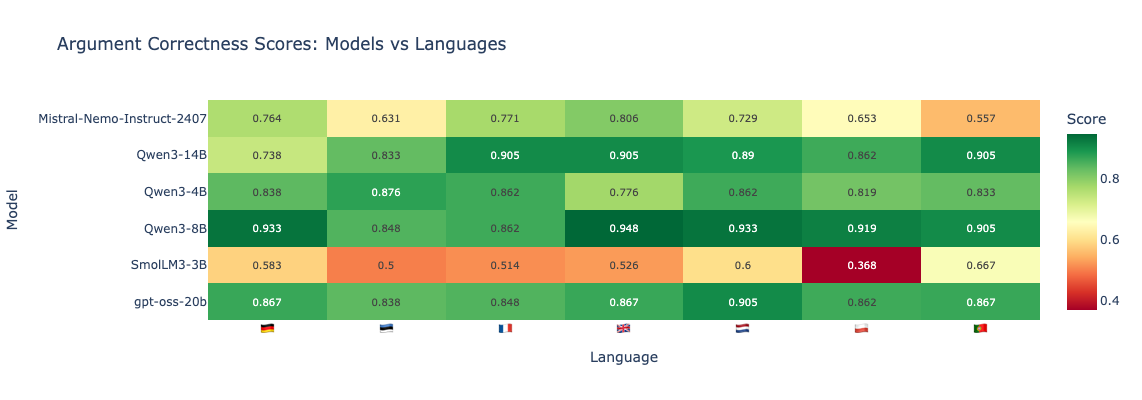

✓ Exported Argument Correctness heatmap


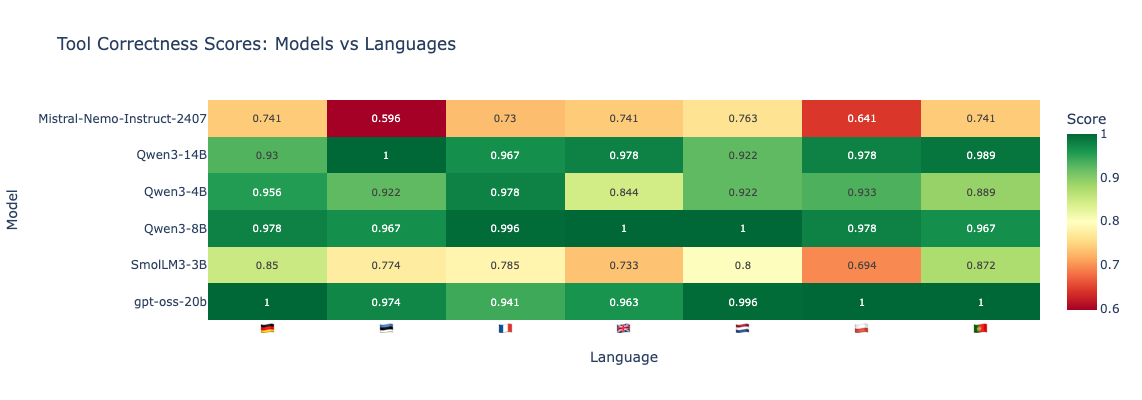

✓ Exported Tool Correctness heatmap


In [109]:
# Create heatmaps showing model performance across languages for each metric
for metric in metrics:
    metric_data = df[df['metric'] == metric]
    
    # Pivot table for heatmap
    pivot_data = metric_data.pivot_table(
        values='score', 
        index='model_clean', 
        columns='country_code', 
        aggfunc='mean'
    )
    pivot_data.columns = [country_to_flag(c) for c in pivot_data.columns]
    
    # Create heatmap using plotly
    fig = px.imshow(
        pivot_data,
        title=f"{metric} Scores: Models vs Languages",
        labels=dict(x="Language", y="Model", color="Score"),
        color_continuous_scale="RdYlGn",
        aspect="auto"
    )
    
    # Add text annotations
    fig.update_traces(
        text=pivot_data.round(3).values,
        texttemplate="%{text}",
        textfont={"size": 10}
    )
    
    fig.update_layout(
        height=400,
        xaxis={'side': 'bottom'},
        yaxis={'side': 'left'}
    )
    
    fig.show()
    
    # Export to HTML
    metric_filename = metric.replace(' ', '_').replace('/', '_').lower()
    fig.write_html(f"{docs_dir}/{metric_filename}_heatmap.html")
    print(f"✓ Exported {metric} heatmap")

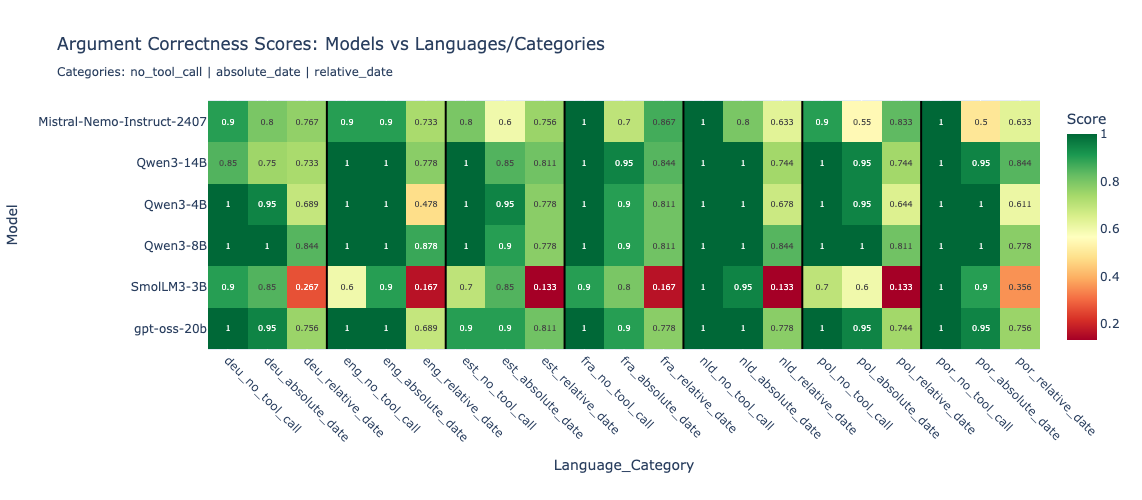

✓ Exported Argument Correctness detailed category heatmap
\nArgument Correctness - Category Performance Summary:
               Tests  Mean Score  Std Dev
category                                 
no_tool_call     420      0.9536   0.2092
absolute_date    840      0.8893   0.3140
relative_date    630      0.6624   0.3707


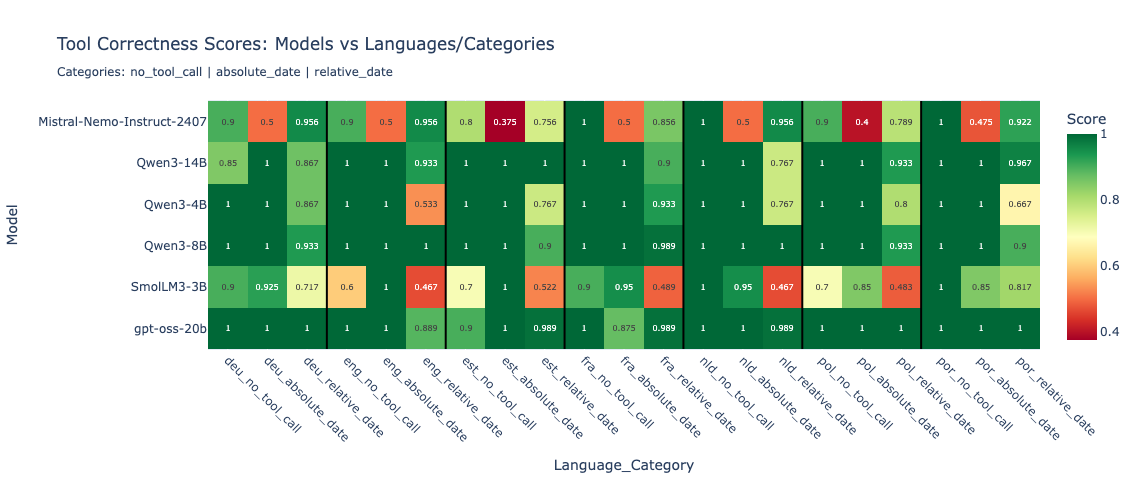

✓ Exported Tool Correctness detailed category heatmap
\nTool Correctness - Category Performance Summary:
               Tests  Mean Score  Std Dev
category                                 
no_tool_call     420      0.9536   0.2092
absolute_date    840      0.8964   0.2303
relative_date    630      0.8419   0.3250


In [110]:
# Create detailed category breakdown heatmaps
for metric in metrics:
    metric_data = detailed_df[detailed_df['metric'] == metric]
    
    # Calculate mean scores for each model-language-category combination
    detailed_pivot = metric_data.groupby(['model_clean', 'language', 'category'])['score'].mean().reset_index()
    
    # Create a pivot table with language_category as columns
    pivot_detailed = detailed_pivot.pivot_table(
        values='score',
        index='model_clean', 
        columns=['language', 'category'],
        aggfunc='mean'
    )
    
    # Flatten column names to create readable labels
    pivot_detailed.columns = [f"{lang}_{cat}" for lang, cat in pivot_detailed.columns]
    
    # Reorder columns to group by language
    languages = sorted(detailed_df['language'].unique())
    categories = ['no_tool_call', 'absolute_date', 'relative_date']
    ordered_cols = []
    for lang in languages:
        for cat in categories:
            col_name = f"{lang}_{cat}"
            if col_name in pivot_detailed.columns:
                ordered_cols.append(col_name)
    
    pivot_detailed = pivot_detailed[ordered_cols]
    
    # Create heatmap
    fig = px.imshow(
        pivot_detailed,
        title=f"{metric} Scores: Models vs Languages/Categories<br><sub>Categories: no_tool_call | absolute_date | relative_date</sub>",
        labels=dict(x="Language_Category", y="Model", color="Score"),
        color_continuous_scale="RdYlGn",
        aspect="auto"
    )
    
    # Add text annotations
    fig.update_traces(
        text=pivot_detailed.round(3).values,
        texttemplate="%{text}",
        textfont={"size": 8}
    )
    
    # Customize layout for better readability
    fig.update_layout(
        height=500,
        xaxis={'tickangle': 45, 'side': 'bottom'},
        yaxis={'side': 'left'},
        margin=dict(b=150)  # Extra bottom margin for rotated labels
    )
    
    # Add vertical lines to separate language groups
    shapes = []
    for i, lang in enumerate(languages[:-1]):  # Don't add line after last language
        x_pos = (i + 1) * len(categories) - 0.5
        shapes.append(
            dict(
                type="line",
                x0=x_pos, x1=x_pos,
                y0=-0.5, y1=len(pivot_detailed.index) - 0.5,
                line=dict(color="black", width=2)
            )
        )
    
    fig.update_layout(shapes=shapes)
    fig.show()
    
    # Export to HTML
    metric_filename = metric.replace(' ', '_').replace('/', '_').lower()
    fig.write_html(f"{docs_dir}/{metric_filename}_detailed_category_heatmap.html")
    print(f"✓ Exported {metric} detailed category heatmap")
    
    # Print summary statistics for this detailed breakdown
    print(f"\\n{metric} - Category Performance Summary:")
    category_summary = metric_data.groupby(['category'])['score'].agg(['count', 'mean', 'std']).round(4)
    category_summary.columns = ['Tests', 'Mean Score', 'Std Dev']
    print(category_summary.sort_values('Mean Score', ascending=False))

Performance by Language (averaged across all models and metrics):


,Mean Score,Std Dev,Data Points
language,,,
nld,0.8602,0.1176,12
por,0.8492,0.1332,12
deu,0.8481,0.1232,12
fra,0.8465,0.1350,12
eng,0.8405,0.1354,12
est,0.8133,0.1602,12
pol,0.8089,0.1875,12


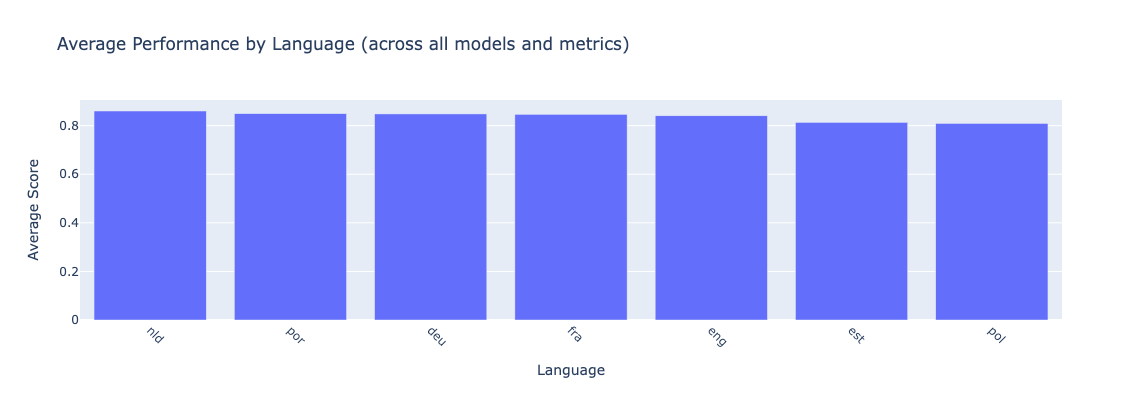

In [66]:
# Language performance analysis
print("Performance by Language (averaged across all models and metrics):")
lang_performance = df.groupby('language')['score'].agg(['mean', 'std', 'count']).round(4)
lang_performance.columns = ['Mean Score', 'Std Dev', 'Data Points']
lang_performance_sorted = lang_performance.sort_values('Mean Score', ascending=False)

display(lang_performance_sorted)

# Create bar chart for language performance
fig = px.bar(
    x=lang_performance_sorted.index,
    y=lang_performance_sorted['Mean Score'],
    title="Average Performance by Language (across all models and metrics)",
    labels={"x": "Language", "y": "Average Score"}
)

fig.update_layout(
    height=400,
    xaxis={'tickangle': 45}
)

fig.show()

fig.write_html(f"{docs_dir}/language_performance_bar_chart.html")

## Interesting examples to show

* ID 4 of Mistral-Nemo-Instruct-2407 deu and eng, tool call for time (how wrong is this?)
* ID 13 of Mistral-Nemo-Instruct-2407 est, decides to get current date for absolute time
* ID 32 of gpt-oss-20b eng, wrong thinking for relative date

## Is Dutch the best language to implements agents in?

I wouldn't conclude that Dutch is the "best language to implement agents in" because:

1. Marginal difference: The gap between Dutch (0.8602) and German/English is very small (~0.011)
2. Statistical significance: With those standard deviations (0.1176 for Dutch), the differences might not be statistically significant
3. Dataset specificity: This reflects performance on your specific evaluation dataset, not general agent capability
3. Practical considerations: English still dominates in:
- Available training data
- Tool/API documentation
- Developer resources
- Real-world deployment scenarios

The results suggest Dutch performs slightly better on your specific multilingual agent tasks, but for practical agent development, English remains the most viable choice due to ecosystem advantages. The small performance difference likely doesn't outweigh English's substantial practical benefits.

### You are absolutely right!

Exactly! It's a great example of how data can be misleading without proper context. The 0.007 difference between Dutch and German could easily be within the margin of error, especially with different sample sizes.

Plus, even if Dutch genuinely performed 1-2% better on this specific benchmark, the practical reality is that you'd still choose English for agent development because:

- 99% of Stack Overflow answers are in English
- All major ML/AI libraries have English docs
- Your team probably thinks in English when coding
- Users expect English interfaces in most contexts

It's similar to how a car might get 0.1 MPG better fuel economy, but if there are no gas stations that sell its special fuel, it's not actually the better choice!

Your evaluation results are valuable for understanding model capabilities across languages, but the "best" language for implementation involves many more factors than just benchmark scores.

In [131]:
# Load all result files
results_dir = Path('results')
results_data = []

lang_to_country = {
    "nld": "NL", 
    "pol": "PL",
    "por": "PT", 
    "est": "EE",
    "deu": "DE", 
    "fra": "FR", 
    "eng": "GB",
}

for json_file in results_dir.glob('*.json'):
    with open(json_file, 'r') as f:
        data = json.load(f)
        
    # Extract model name and language from filename or data
    model_name = data.get('model_name', '')
    language = data.get('language', '')
    
    # Get metric scores
    metric_score = data['evaluation_results']['global_metrics']['overall_pass_rate']
    results_data.append({
            'model': model_name,
            'language': language,
            'metric': "overall_pass_rate",
            'score': metric_score,
            'filename': json_file.name
        })
    
    # # Add each metric score as a separate row
    # for metric_name, score in metric_scores.items():
    #     results_data.append({
    #         'model': model_name,
    #         'language': language,
    #         'metric': metric_name,
    #         'score': score,
    #         'filename': json_file.name
    #     })

# Create DataFrame
df_pass_rate = pd.DataFrame(results_data)
df_pass_rate['country_code'] = df_pass_rate['language'].map(lang_to_country)
# df_pass_rate['required_vram'] = df_pass_rate['model'].map(models_memory_gb)
print(f"Loaded {len(df_pass_rate)} data points")
print(f"Models: {sorted(df_pass_rate['model'].unique())}")
print(f"Languages: {sorted(df_pass_rate['language'].unique())}")
print(f"Metrics: {sorted(df_pass_rate['metric'].unique())}")
df_pass_rate.head()

Loaded 42 data points
Models: ['HuggingFaceTB/SmolLM3-3B', 'Qwen/Qwen3-14B', 'Qwen/Qwen3-4B', 'Qwen/Qwen3-8B', 'mistralai/Mistral-Nemo-Instruct-2407', 'openai/gpt-oss-20b']
Languages: ['deu', 'eng', 'est', 'fra', 'nld', 'pol', 'por']
Metrics: ['overall_pass_rate']


,model,language,metric,score,filename,country_code
0,HuggingFaceTB/SmolLM3-3B,nld,overall_pass_rate,64.44,agent_SmolLM3-3B_nld_Latn.json,NL
1,openai/gpt-oss-20b,pol,overall_pass_rate,80.00,agent_gpt-oss-20b_pol_Latn.json,PL
2,Qwen/Qwen3-8B,por,overall_pass_rate,84.44,agent_Qwen3-8B_por_Latn.json,PT
3,Qwen/Qwen3-8B,est,overall_pass_rate,80.00,agent_Qwen3-8B_est_Latn.json,EE
4,Qwen/Qwen3-14B,nld,overall_pass_rate,86.67,agent_Qwen3-14B_nld_Latn.json,NL


In [132]:
# Clean model names for better visualization
def clean_model_name(model_name):
    """Extract clean model name from full model path"""
    if '/' in model_name:
        return model_name.split('/')[-1]
    return model_name

df_pass_rate['model_clean'] = df_pass_rate['model'].apply(clean_model_name)
print(f"Clean model names: {sorted(df_pass_rate['model_clean'].unique())}")

Clean model names: ['Mistral-Nemo-Instruct-2407', 'Qwen3-14B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM3-3B', 'gpt-oss-20b']


In [153]:
# assuming 4,096 tokens and INT4 (ollama) - see https://apxml.com/models

models_memory_gb = {
    "Mistral-Nemo-Instruct-2407": 12,
    "Qwen3-4B": 4,
    "Qwen3-8B": 7,
    "Qwen3-14B": 11,
    "SmolLM3-3B": 4,
    "gpt-oss-20b": 17,
}

In [160]:
mean_scores_df = df_pass_rate.groupby('model_clean')['score'].mean().sort_values().reset_index()
mean_scores_df.columns = ['model', 'mean_score']
mean_scores_df["mean_score"] = round(mean_scores_df["mean_score"], 2)

mean_scores_df['required_vram'] = mean_scores_df['model'].map(models_memory_gb)
mean_scores_df['performance_per_vram_gb'] = round(mean_scores_df['mean_score'] / mean_scores_df['required_vram'], 2)

In [161]:
mean_scores_df

,model,mean_score,required_vram,performance_per_vram_gb
0,Mistral-Nemo-Instruct-2407,31.75,12,2.65
1,SmolLM3-3B,54.60,4,13.65
2,gpt-oss-20b,81.59,17,4.80
3,Qwen3-14B,82.67,11,7.52
4,Qwen3-4B,82.86,4,20.72
5,Qwen3-8B,86.67,7,12.38


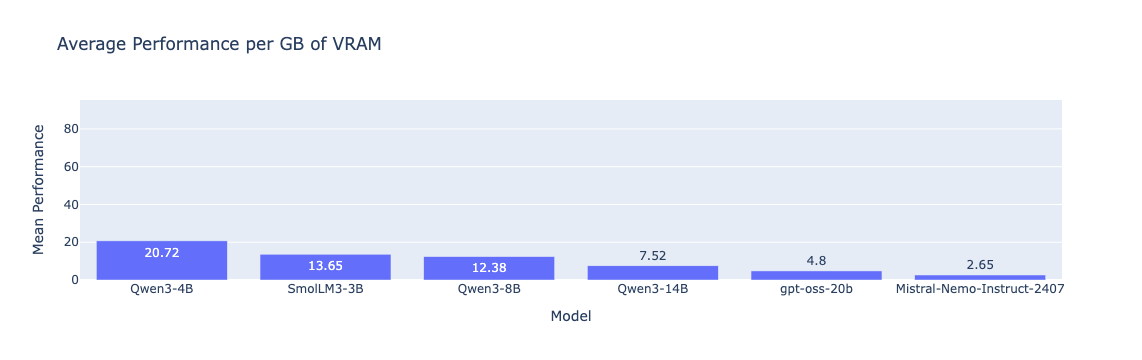

In [162]:
fig = px.bar(
    mean_scores_df.sort_values(by='performance_per_vram_gb', ascending=False),               # DataFrame
    x='model',              # Column for x-axis
    y='performance_per_vram_gb',               # Column for y-axis
    title='Average Performance per GB of VRAM', # Optional title
    text='performance_per_vram_gb'             # Optional: show values on bars
)

# Optional: improve layout
fig.update_layout(
    xaxis_title='Model',
    yaxis_title='Mean Performance',
    yaxis=dict(range=[0, mean_scores_df['mean_score'].max() * 1.1])  # give some padding
)

# Show the plot
fig.show()

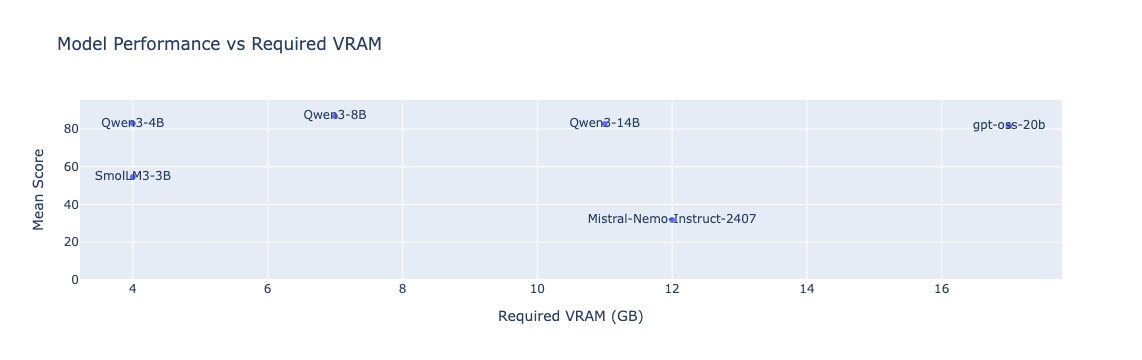

In [166]:
# Scatter plot to show mean_score vs required VRAM
fig = px.scatter(
    mean_scores_df,           
    x='required_vram', 
    y='mean_score',    
    text='model',     
    title='Model Performance vs Required VRAM',
    # size='mean_score',
    # color='mean_score',      
    color_continuous_scale='Viridis'
)

# Optional: adjust layout
fig.update_layout(
    xaxis_title='Required VRAM (GB)',
    yaxis_title='Mean Score',
    yaxis=dict(range=[0, mean_scores_df['mean_score'].max() * 1.1])
)

fig.show()